In [1]:
import pandas as pd
import polars as pl
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
# could be problematic in future (ie. deprecations)
warnings.filterwarnings('ignore')

In [2]:
base = pd.read_csv("C:/Users/tomco/OneDrive - UNSW/2024\FINS3666/top30_1hr.csv")
# renaming columns
base.columns = ['open_timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_timestamp', 'quote_volume', 'count', 'taker_buy_volume', 'taker_quote_volume', 'ignore', 'ticker']
# selecting OHLC data and other relevant information
base = base.drop(columns = ['close_timestamp', 'taker_buy_volume', 'taker_quote_volume', 'ignore'])

# extracting timestamp, price and ticker data
subset = base[['open_timestamp', 'open', 'ticker']]
subset.head()

,open_timestamp,open,ticker
0,1.725149e+12,58941.9,BTCUSDT
1,1.725152e+12,58905.3,BTCUSDT
2,1.725156e+12,58804.1,BTCUSDT
3,1.725160e+12,58513.1,BTCUSDT
4,1.725163e+12,58501.6,BTCUSDT


In [3]:
# pivot from wide to long dataframe
main = subset.pivot(index = 'open_timestamp',
                    columns = 'ticker',
                    values = 'open')
main.index = pd.to_datetime(main.index, unit = 'ms')
#main = main.rename_axis('timestamp')
main.tail()

ticker,1000PEPEUSDT,1000SHIBUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,LINKUSDT,LTCUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TAOUSDT,TONUSDT,TRXUSDT,UNIUSDT,XRPUSDT
open_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-30 19:00:00,0.010818,0.017836,0.3801,7.8775,28.139,341.99,571.64,63306.8,0.11806,4.534,...,11.969,67.28,5.434,154.875,1.8283,580.59,5.8383,0.15662,7.525,0.6219
2024-09-30 20:00:00,0.010769,0.017730,0.3792,7.8828,27.937,340.88,573.07,63472.9,0.11775,4.517,...,11.966,67.30,5.364,155.044,1.8042,579.50,5.8428,0.15669,7.452,0.6224
2024-09-30 21:00:00,0.010937,0.018069,0.3806,7.9192,28.250,343.67,575.41,63788.8,0.11872,4.535,...,12.032,67.37,5.382,156.676,1.8185,597.04,5.8264,0.15680,7.589,0.6237
2024-09-30 22:00:00,0.010787,0.018011,0.3815,7.8972,28.098,342.07,573.62,63678.8,0.11780,4.515,...,11.969,67.25,5.405,155.724,1.8153,589.00,5.8166,0.15660,7.520,0.6231
2024-09-30 23:00:00,0.010531,0.017805,0.3762,7.7627,27.777,338.59,570.55,63458.3,0.11586,4.466,...,11.877,67.00,5.300,154.336,1.7818,574.59,5.7853,0.15650,7.453,0.6189


In [4]:
# forward fill NAs and take daily observations
main_hourly = main.ffill()
main_daily = main_hourly[main_hourly.index.time == pd.Timestamp('00:00:00').time()]

In [5]:
# adjusting for funding rate and calculating percentage returns
funding_hourly = 0.1095 / (365 * 24)
funding_adjusted_hourly = main_hourly.pct_change() - funding_hourly
funding_adjusted_hourly.tail()

funding_daily = 0.1095 / 365
funding_adjusted_daily = main_daily.pct_change() - funding_daily
funding_adjusted_daily.tail()

ticker,1000PEPEUSDT,1000SHIBUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,LINKUSDT,LTCUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TAOUSDT,TONUSDT,TRXUSDT,UNIUSDT,XRPUSDT
open_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-26,-0.017437,0.028032,-0.018097,-0.017576,-0.042110,-0.013185,-0.030941,-0.017810,-0.012147,0.000132,...,-0.003592,-0.002400,-0.038279,-0.031843,-0.025732,0.003008,0.021016,-0.008307,-0.022108,-0.014010
2024-09-27,0.126687,0.221886,0.053534,0.005739,0.068672,0.024232,0.014968,0.031716,0.089159,0.037888,...,0.036697,0.029916,0.077880,0.050986,-0.034525,-0.047058,0.009011,0.020512,0.085186,0.012571
2024-09-28,0.124496,0.086920,0.000946,0.054232,0.043332,0.019294,0.017924,0.009071,0.044904,0.014455,...,0.008540,0.037348,-0.016895,0.013277,0.009886,0.043658,0.032161,0.013227,0.035473,-0.003180
2024-09-29,0.063089,-0.031797,-0.003784,-0.052035,-0.038032,-0.018318,-0.010525,0.000813,0.036794,-0.018322,...,0.021329,-0.016894,0.019326,-0.006062,0.017935,-0.025204,-0.016430,-0.000558,-0.002401,0.042521
2024-09-30,-0.009271,-0.014573,-0.008042,0.001610,-0.009010,0.000552,-0.009200,-0.004166,-0.029195,-0.006557,...,-0.037620,-0.010310,-0.010734,0.010569,0.042217,0.045963,-0.006644,0.008019,-0.019908,0.044510


In [6]:
# estimating beta, daily timeframe
betas_daily = pd.DataFrame(index = funding_adjusted_daily.index)
window_size = 30
benchmark_returns = funding_adjusted_daily.iloc[:, 7]

def rollingBeta(asset_returns, benchmark_returns, window):
    rolling_cov = asset_returns.rolling(window).cov(benchmark_returns)
    rolling_var = benchmark_returns.rolling(window).var()
    rolling_beta = rolling_cov / rolling_var
    return rolling_beta

for column in funding_adjusted_daily.columns:
    asset_returns = funding_adjusted_daily[column]
    betas_daily[column] = rollingBeta(asset_returns, benchmark_returns, window_size)
    
betas_daily.tail()

# estimating beta, hourly timeframe
betas_hourly = pd.DataFrame(index = funding_adjusted_hourly.index)
window_size = 30 * 24
benchmark_returns = funding_adjusted_hourly.iloc[:, 7]

def rolling_beta(asset_returns, benchmark_returns, window):
    rolling_cov = asset_returns.rolling(window).cov(benchmark_returns)
    rolling_var = benchmark_returns.rolling(window).var()
    rolling_beta = rolling_cov / rolling_var
    return rolling_beta

for column in funding_adjusted_hourly.columns:
    asset_returns = funding_adjusted_hourly[column]
    betas_hourly[column] = rolling_beta(asset_returns, benchmark_returns, window_size)
    
betas_hourly.tail()

,1000PEPEUSDT,1000SHIBUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,LINKUSDT,LTCUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TAOUSDT,TONUSDT,TRXUSDT,UNIUSDT,XRPUSDT
open_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-30 19:00:00,1.598889,1.183276,1.013888,1.139811,1.261996,0.963723,0.845013,1.0,1.108763,1.006611,...,1.075588,0.746636,1.503061,1.247898,1.434732,1.705248,0.850591,0.179229,1.085704,0.637544
2024-09-30 20:00:00,1.597554,1.181688,1.013326,1.139801,1.260526,0.962857,0.845206,1.0,1.107627,1.005548,...,1.075290,0.746513,1.500222,1.247395,1.431898,1.704173,0.850259,0.179174,1.083634,0.637557
2024-09-30 21:00:00,1.599966,1.185903,1.013234,1.139589,1.261962,0.963950,0.845348,1.0,1.108443,1.005449,...,1.075451,0.745900,1.499199,1.248669,1.432211,1.711126,0.847671,0.179111,1.087738,0.637366
2024-09-30 22:00:00,1.600832,1.186072,1.012834,1.139098,1.262279,0.964175,0.845590,1.0,1.109036,1.005314,...,1.075580,0.745472,1.497707,1.248925,1.431519,1.712263,0.847472,0.179482,1.088758,0.637713
2024-09-30 23:00:00,1.605031,1.187871,1.015136,1.142359,1.263838,0.965675,0.846158,1.0,1.111879,1.006933,...,1.076341,0.745602,1.500862,1.249870,1.434632,1.716691,0.848049,0.179612,1.089889,0.638859


In [7]:
# adjusting returns for beta
adjusted_hourly = funding_adjusted_hourly / betas_hourly
adjusted_daily = funding_adjusted_daily / betas_daily

In [8]:
def backAdjust(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Adjusts prices DataFrame such that first observation for each asset is equal to 1

    Args:
        prices (pd.DataFrame): raw asset prices

    Returns:
        pd.DataFrame: DataFrame of back-adjusted prices
    """
    
    adjusted = prices.apply(lambda col: col / col[col.first_valid_index()] if col.notna().any() else col, axis=0)
    
    return adjusted

backadj_daily = backAdjust(main_daily)

# then adjust these for funding

In [9]:
def breakoutIndividual(prices: pd.DataFrame, period: int) -> pd.DataFrame:
    """
    Generates signals for the Breakout strategy for a specific period
    
    Args:
        prices (pandas.Dataframe): A DataFrame consisting of x observations of 50 different assets
        period (int): Defined lookback period for the price range for the breakout signal
    
    Returns:
        pandas.Dataframe: A DataFrame consisting of the signals for each of the assets
    """
    
    # calculate the rolling mean, max and min for each the dataframe
    rolling_mean = prices.rolling(period, min_periods=1).mean()
    rolling_max = prices.rolling(period, min_periods=1).max()
    rolling_min = prices.rolling(period, min_periods=1).min()
        
    # calculate the raw forecast
    raw_forecast = 40 * (prices - rolling_mean) / (rolling_max - rolling_min)
    
    # smooth the forecast
    smoothed_forecast = raw_forecast.ewm(span = period / 4, adjust = False).mean()
    
    # cap the forecast
    capped_forecast = smoothed_forecast.map(lambda x: -20 if x < -20 else (20 if x > 20 else x))
    capped_forecast.iloc[0] = 0
    
    # return the capped forecast
    return capped_forecast

In [10]:
def breakoutEnsemble(prices: pd.DataFrame, periods: list) -> pd.DataFrame:
    """
    Generates signals for the Breakout strategy for multiple periods
    
    Args:
        prices (pandas.Dataframe): A DataFrame consisting of x observations of 50 different assets
    
    Returns:
        pandas.Dataframe: A DataFrame consisting of the signals for each of the assets
    """
    
    # initialise an empty DataFrame with the same index and columns as prices
    average_forecast = pd.DataFrame(index=prices.index, columns=prices.columns)
    
    # apply breakoutIndividual to each period and add the results to average_forecast
    for period in periods:
        df = breakoutIndividual(prices, period)
        average_forecast = average_forecast.add(df, fill_value=0)
    
    # Divide by the number of periods to get the average
    average_forecast = average_forecast / len(periods)
    
    return average_forecast * 1.1

#breakoutEnsemble(backadj_daily, [8, 16, 32]).tail()
breakoutEnsemble(backadj_daily, [4, 8, 16, 32, 64]).abs().mean()

ticker
1000PEPEUSDT     9.412441
1000SHIBUSDT     9.249027
ADAUSDT          9.746571
APTUSDT          9.566291
AVAXUSDT         9.851058
BCHUSDT          8.792476
BNBUSDT          9.400476
BTCUSDT           9.86483
DOGEUSDT         8.873532
DOTUSDT          9.659401
ETCUSDT           9.01467
ETHUSDT          9.684934
FETUSDT          9.559011
ICPUSDT          9.165655
KASUSDT          8.389796
LINKUSDT         9.132631
LTCUSDT          8.698844
NEARUSDT         9.879206
SOLUSDT          9.786898
SUIUSDT         10.398194
TAOUSDT         10.051448
TONUSDT          9.285734
TRXUSDT          9.019168
UNIUSDT          9.284247
XRPUSDT          8.762841
dtype: object

In [12]:
def ensTrend(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a series of prices, processes trend following signals based on exponentially-weighted moving average crossovers and outputs position signals.
    
    Args:
        prices (pandas DataFrame): series of back-adjusted price data for 50 assets
        
    Returns:
        pandas DataFrame: trend following signals scaled from -20 to 20
    """
    
    # creating the EMA ensemble
    ema8 = prices.ewm(span=8, min_periods=1).mean()
    ema16 = prices.ewm(span=16, min_periods=1).mean()
    ema32 = prices.ewm(span=32, min_periods=1).mean()
    ema64 = prices.ewm(span=64, min_periods=1).mean()
    ema128 = prices.ewm(span=128, min_periods=1).mean()
    
    # calculating moving average differences
    emac8 = (ema8 - ema32) * 5.95 / prices
    emac16 = (ema16 - ema64) * 4.10 / prices
    emac32 = (ema32 - ema128) * 2.79 / prices
    
    # creating raw forecasts
    raw_forecast = 25 * (emac8 + emac16 + emac32) / 3
    
    # scale by volatility?
    
    # capped forecasts
    capped_forecast = raw_forecast.map(lambda x: -20 if x < -20 else (20 if x > 20 else x))
    capped_forecast.iloc[0] = 0
    
    # return the capped forecast
    return capped_forecast

ensTrend(backadj_daily).tail()
#ensTrend(backadj_daily).abs().mean()

ticker,1000PEPEUSDT,1000SHIBUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,LINKUSDT,LTCUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TAOUSDT,TONUSDT,TRXUSDT,UNIUSDT,XRPUSDT
open_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-26,-2.444822,-2.974834,-1.214090,5.686429,2.787674,-2.151627,3.760781,1.990150,-2.042603,-6.535222,...,-1.652028,-0.782378,2.035377,0.352698,18.930106,16.729720,-3.707308,3.620881,-2.228287,2.519891
2024-09-27,-0.363044,0.276368,-0.002849,6.278421,3.476667,-1.611438,3.911135,2.347257,-0.688349,-5.238895,...,-0.560485,-0.327751,3.501640,1.159602,20.000000,18.449268,-3.238037,3.623477,-1.075623,2.551511
2024-09-28,2.257335,3.144766,0.898851,7.005059,4.459027,-0.971078,4.195206,2.746962,0.741819,-4.159136,...,0.342898,0.442822,4.609829,1.930276,20.000000,18.756090,-2.415606,3.776826,0.109168,2.561283
2024-09-29,4.707768,5.147625,1.554524,7.550547,5.042795,-0.725203,4.370262,3.069628,2.185559,-3.646482,...,1.267677,0.840581,5.526592,2.475580,20.000000,19.691505,-2.072395,3.912719,0.970684,2.940091
2024-09-30,6.637851,6.514009,1.972868,7.646470,5.272658,-0.507406,4.382605,3.272703,3.051936,-3.270209,...,1.591436,1.027204,6.216333,2.976609,20.000000,19.593497,-1.852785,4.064853,1.422093,3.674484


In [13]:
def signalAggregate(adj_prices: pd.DataFrame, continuous_sizing=True) -> pd.DataFrame:
    """
    Combine strategy signals to form aggregrate signals for position sizing 

    Args:
        adj_prices (pd.DataFrame): back-adjusted prices
        raw_prices (pd.DataFrame): raw asset prices

    Returns:
        pd.DataFrame: number of units per asset to be bought/(sold)
    """
    
    # perform signal calculations for the available strategies
    trend_signals = ensTrend(adj_prices)
    breakout_signals = breakoutEnsemble(prices=adj_prices, periods=[8, 16, 32])
    
    # take mean of both signals
    system_signals = (trend_signals + breakout_signals) / 2
    
    return system_signals

sample_signals = signalAggregate(backadj_daily)
sample_signals.tail()

ticker,1000PEPEUSDT,1000SHIBUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,LINKUSDT,LTCUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TAOUSDT,TONUSDT,TRXUSDT,UNIUSDT,XRPUSDT
open_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-26,5.658772,7.273612,7.871772,11.739218,8.836201,4.270949,9.160187,6.954182,5.439268,5.165627,...,8.161671,4.658399,10.56558,6.45051,19.87796,19.02766,3.534441,-1.052136,2.089724,2.864083
2024-09-27,9.19512,10.399798,9.618856,11.760173,11.895991,6.774854,9.231518,10.551339,9.265208,6.563763,...,9.298654,7.799859,12.180765,9.596209,19.304067,18.768249,5.510356,3.793395,7.447863,4.477638
2024-09-28,11.237512,12.52526,10.548958,13.287523,13.229514,8.508344,10.53484,11.210797,10.664152,7.717567,...,10.143685,10.3138,12.382282,10.763047,18.692958,18.844922,7.360237,7.348731,9.70981,4.311202
2024-09-29,13.055409,13.573813,10.814303,10.890453,12.491689,7.299428,9.771644,11.501003,11.831402,7.42838,...,10.944771,10.052601,12.883316,11.161222,18.478677,18.502377,7.426494,8.614047,10.723364,9.553244
2024-09-30,14.318925,13.906984,10.126993,10.082013,10.873472,6.695797,7.509239,11.012084,12.232345,6.624142,...,9.325621,8.409832,12.425897,11.609225,19.449259,18.676253,6.130424,9.73386,9.992835,11.61791


In [14]:
def simpleWeight(signals: pd.DataFrame) -> pd.DataFrame:
    return signals.fillna(0) / 20

sample_weights = simpleWeight(sample_signals)

def adjustWeights(weights: pd.DataFrame) -> pd.DataFrame:
    row_sums = weights.abs().sum(axis = 1)
    return weights.div(row_sums, axis = 0).fillna(0)

adjusted_weights = adjustWeights(sample_weights)
adjusted_weights.tail()

ticker,1000PEPEUSDT,1000SHIBUSDT,ADAUSDT,APTUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,LINKUSDT,LTCUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TAOUSDT,TONUSDT,TRXUSDT,UNIUSDT,XRPUSDT
open_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-26,0.030561,0.039282,0.042513,0.063399,0.047721,0.023066,0.049471,0.037557,0.029376,0.027898,...,0.044078,0.025158,0.057061,0.034837,0.107354,0.102762,0.019088,-0.005682,0.011286,0.015468
2024-09-27,0.039612,0.044801,0.041437,0.050661,0.051247,0.029185,0.039768,0.045454,0.039913,0.028276,...,0.040058,0.033601,0.052473,0.041339,0.083160,0.080851,0.023738,0.016342,0.032085,0.019289
2024-09-28,0.042538,0.047413,0.039932,0.050298,0.050079,0.032207,0.039878,0.042437,0.040368,0.029214,...,0.038398,0.039041,0.046871,0.040742,0.070760,0.071335,0.027861,0.027818,0.036755,0.016319
2024-09-29,0.048897,0.050839,0.040504,0.040789,0.046786,0.027339,0.036598,0.043076,0.044313,0.027822,...,0.040992,0.037651,0.048253,0.041803,0.069209,0.069298,0.027815,0.032263,0.040163,0.035780
2024-09-30,0.055895,0.054287,0.039531,0.039356,0.042445,0.026137,0.029313,0.042986,0.047750,0.025858,...,0.036403,0.032828,0.048505,0.045317,0.075921,0.072904,0.023930,0.037997,0.039007,0.045351


In [15]:
def rollingStdDev(prices: pd.DataFrame, period: int = 30):
    return prices.rolling(period).std()

annualised_vols = rollingStdDev(funding_adjusted_daily) * np.sqrt(365)

np.float64(1.4270329908328616)

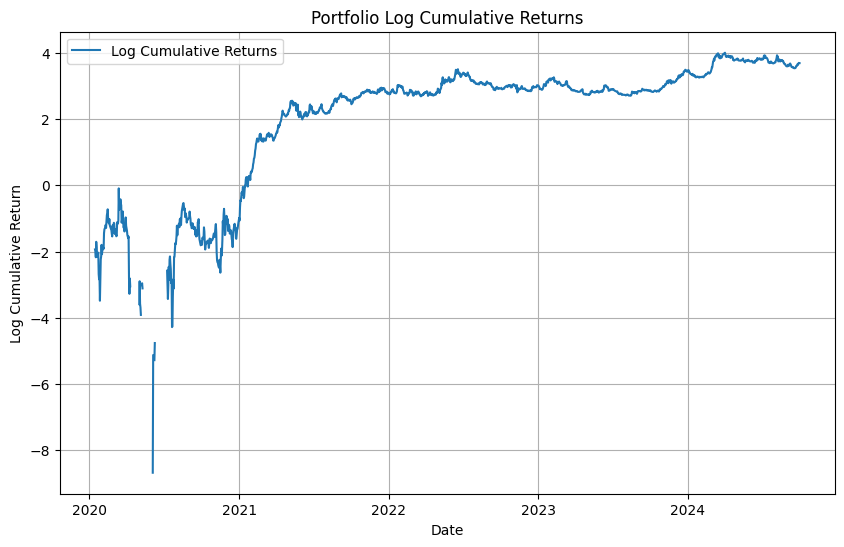

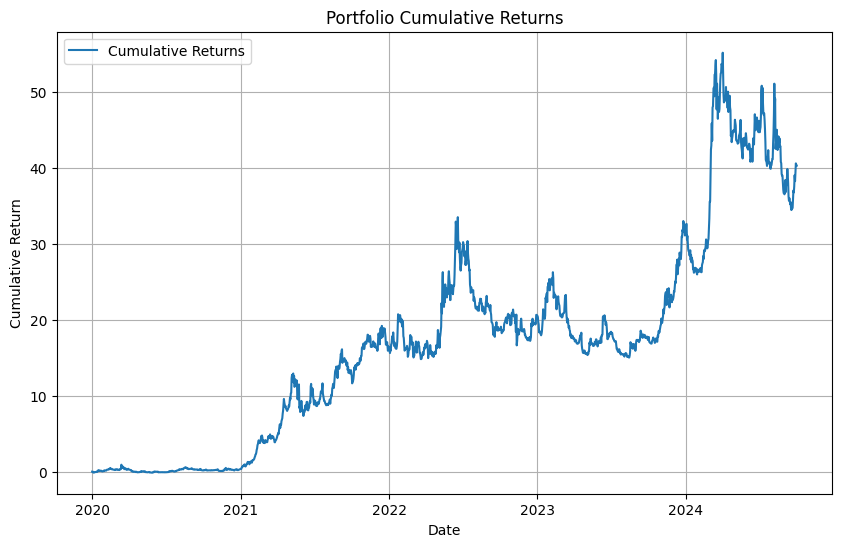

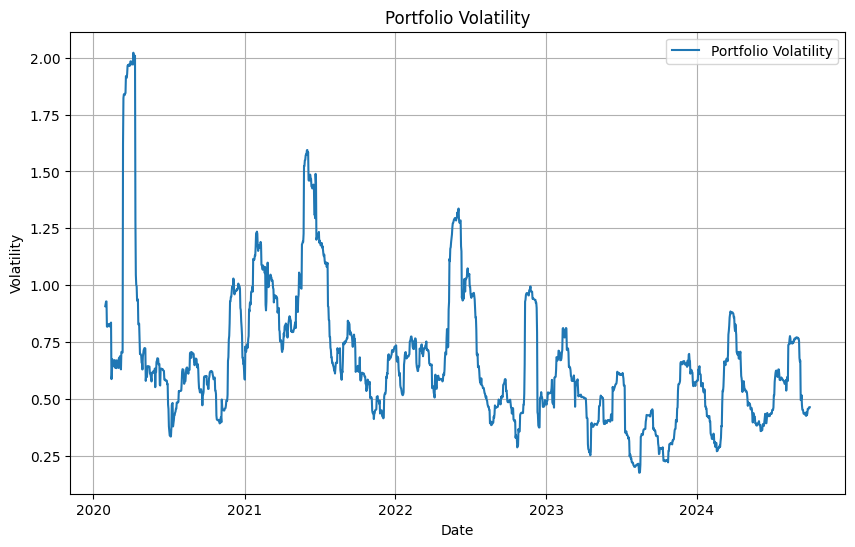

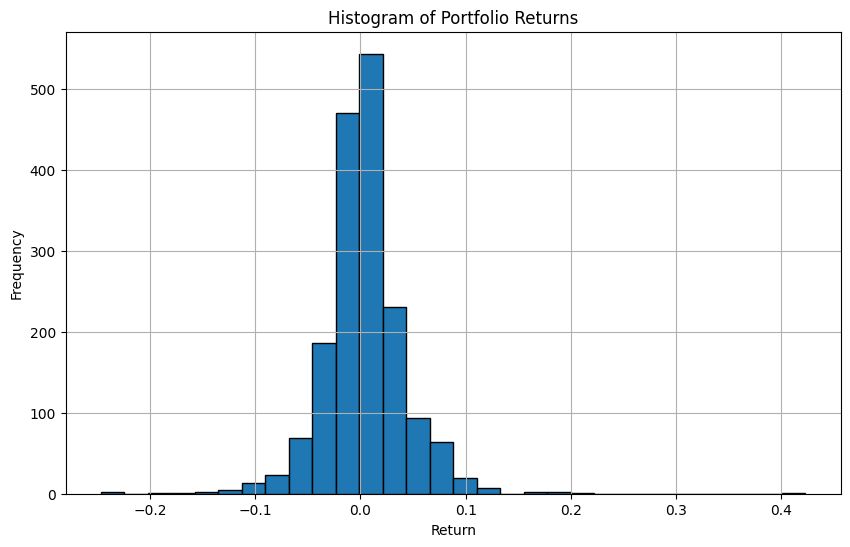

In [16]:
# NO VOLATILITY TARGETING, NO BETA ADJUSTMENT
base_rets = (funding_adjusted_daily * adjusted_weights.shift(1)).sum(axis = 1)
base_cumulative = (1 + base_rets).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(np.log(base_cumulative), label='Log Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Log Cumulative Return')
plt.title('Portfolio Log Cumulative Returns')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(base_cumulative, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True)

ret_stddev = base_rets.rolling(30).std() * np.sqrt(365)
plt.figure(figsize=(10, 6))
plt.plot(ret_stddev, label='Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Portfolio Volatility')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.hist(base_rets, bins=30, edgecolor='black')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Histogram of Portfolio Returns')
plt.grid(True)

# Sharpe Ratio
(base_rets.mean() * 365) / (base_rets.std() * np.sqrt(365))

In [17]:
vol_target = 0.20 / np.sqrt(365)

def volatiltyScale(weights: pd.DataFrame, returns: pd.DataFrame, daily_vol_target: int = 0.25 / np.sqrt(365), window: int = 30):
    scaled_weights = pd.DataFrame(index=weights.index, columns=weights.columns)
    
    for i in range(window, len(weights)):
        # Calculate rolling covariance matrix of asset returns, filling NAs with 0
        rolling_cov_matrix = returns.iloc[:i+1].fillna(0).rolling(window=window).cov().iloc[-weights.shape[1]:]
        
        if rolling_cov_matrix.isna().any().any():
            continue
        
        # Extract the appropriate segment of the covariance matrix
        rolling_cov_matrix = rolling_cov_matrix.iloc[-weights.shape[1]:, -weights.shape[1]:]
        
        # Calculate portfolio variance using current weights and rolling covariance matrix
        portfolio_variance = np.dot(weights.iloc[i].fillna(0), np.dot(rolling_cov_matrix, weights.iloc[i].fillna(0).T))
        
        # Convert variance to standard deviation to get portfolio volatility
        portfolio_volatility = np.sqrt(portfolio_variance)
        
        # Scale factor to adjust weights to meet the daily volatility target
        scale_factor = daily_vol_target / portfolio_volatility
        
        # Ensure scale_factor doesn't result in extremely large values
        scale_factor = np.clip(scale_factor, a_min=0, a_max=10)
        
        # Scale weights
        scaled_weights.iloc[i] = weights.iloc[i] * scale_factor
    
    return scaled_weights

scaled_weights = volatiltyScale(adjusted_weights, funding_adjusted_daily, daily_vol_target=vol_target)

np.float64(1.7438696477684352)

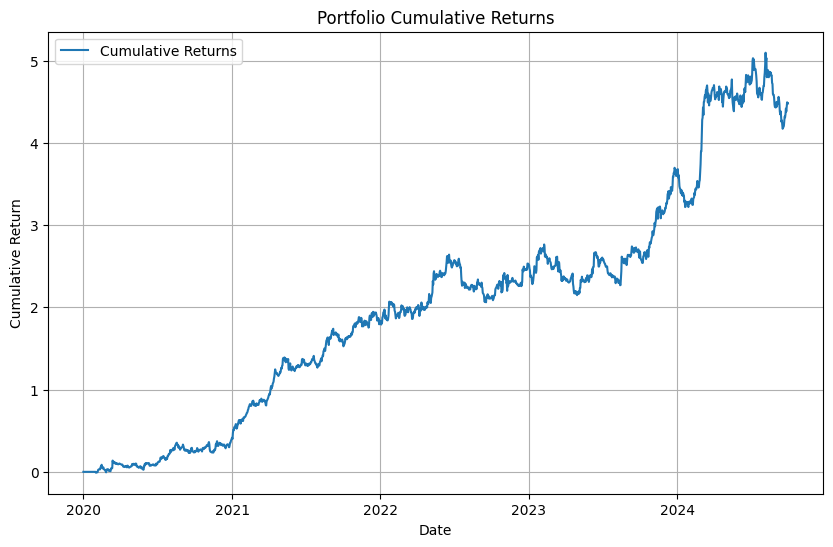

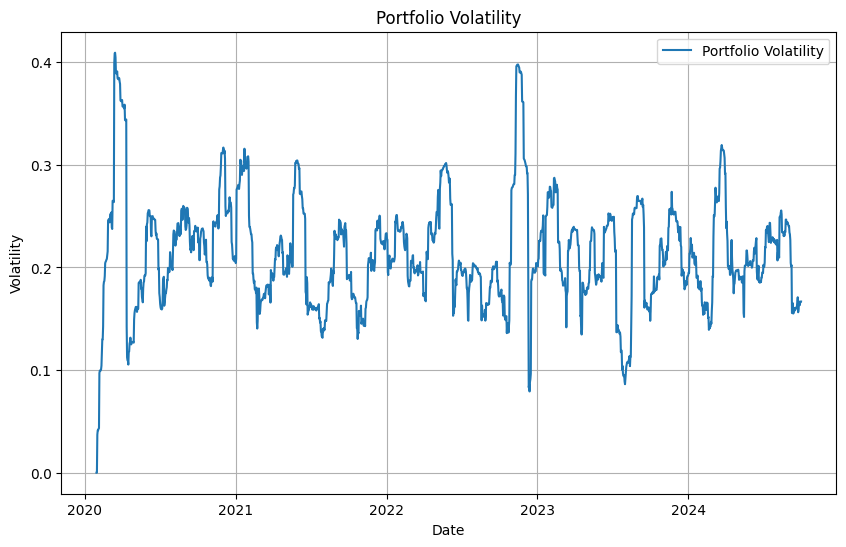

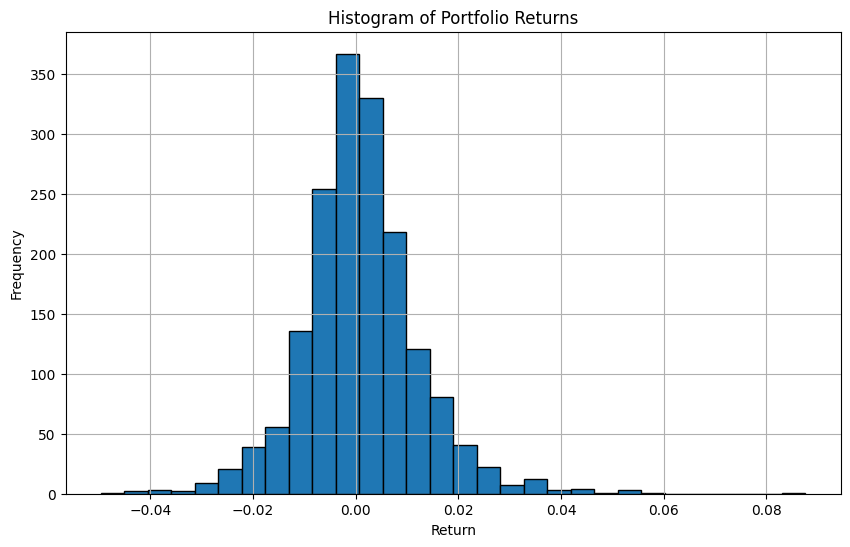

In [18]:
vol_no_fees_rets = (funding_adjusted_daily * scaled_weights.shift(1)).sum(axis = 1)
vol_no_fees_cumulative = (1 + vol_no_fees_rets).cumprod() - 1

'''plt.figure(figsize=(10, 6))
plt.plot(np.log(vol_no_fees_cumulative), label='Log Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Log Cumulative Return')
plt.title('Portfolio Log Cumulative Returns')
plt.legend()
plt.grid(True)
'''
plt.figure(figsize=(10, 6))
plt.plot(vol_no_fees_cumulative, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True)

ret_stddev = vol_no_fees_rets.rolling(30).std() * np.sqrt(365)
plt.figure(figsize=(10, 6))
plt.plot(ret_stddev, label='Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Portfolio Volatility')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.hist(vol_no_fees_rets, bins=30, edgecolor='black')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Histogram of Portfolio Returns')
plt.grid(True)

# Sharpe Ratio
(vol_no_fees_rets.mean() * 365) / (vol_no_fees_rets.std() * np.sqrt(365))

In [19]:
def portfolioValue(cum_returns: pd.Series, initial_value: float = 100) -> pd.DataFrame:
    return initial_value * (1 + cum_returns)

def dollarWeighting(portfolio_values: pd.Series, weights: pd.DataFrame) -> pd.DataFrame:
    dollar_weights = weights.multiply(portfolio_values, axis = 0)
    return dollar_weights

portfolio_value = portfolioValue(vol_no_fees_cumulative)
dollar_weights = dollarWeighting(portfolio_value, scaled_weights)
position_units = dollar_weights.div(main_daily).fillna(0)

In [48]:
initial_value = 100
fee = 0.002

portfolio_values = pd.Series(index=funding_adjusted_daily.index)
portfolio_values.iloc[0] = initial_value

dollar_weights = pd.DataFrame(index=scaled_weights.index, columns=scaled_weights.columns)

for member in tqdm(range(1, len(vol_no_fees_rets))):
    # calculate current value of portfolio
    current_value = portfolio_values.iloc[member - 1] * (1 + vol_no_fees_rets[member])
    
    # calculate dollar weights
    dollar_weights.iloc[member] = current_value * scaled_weights.iloc[member]
    
    # calculate number of units held
    units_held = dollar_weights.div(main_daily).fillna(0)
    
    # calculate the change in units held
    diff_units_held = units_held.diff().abs()
    
    # calculate transaction cost
    tx_cost = diff_units_held.mul(main_daily).sum(axis=1).iloc[member] * fee
    
    # subtract transaction cost from current portfolio value
    new_value = current_value - tx_cost
    
    # store the new portfolio value
    portfolio_values.iloc[member] = new_value

100%|██████████| 1734/1734 [00:39<00:00, 43.99it/s]


open_timestamp
2024-09-26    341.721630
2024-09-27    345.011731
2024-09-28    348.762691
2024-09-29    347.757990
2024-09-30    347.782488
dtype: float64
0.22002480349700376


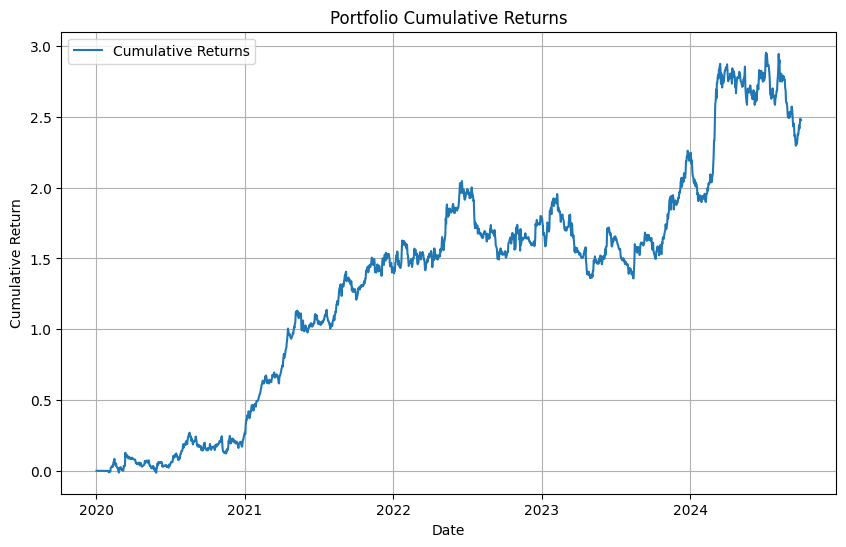

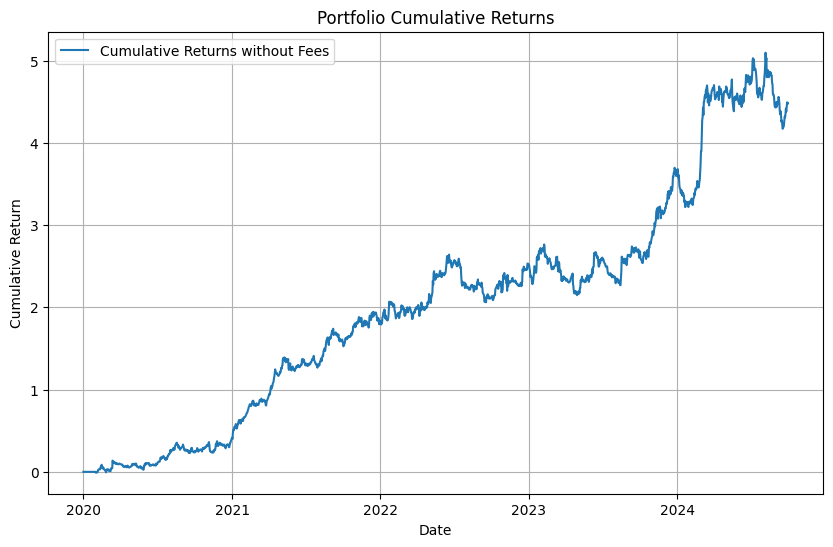

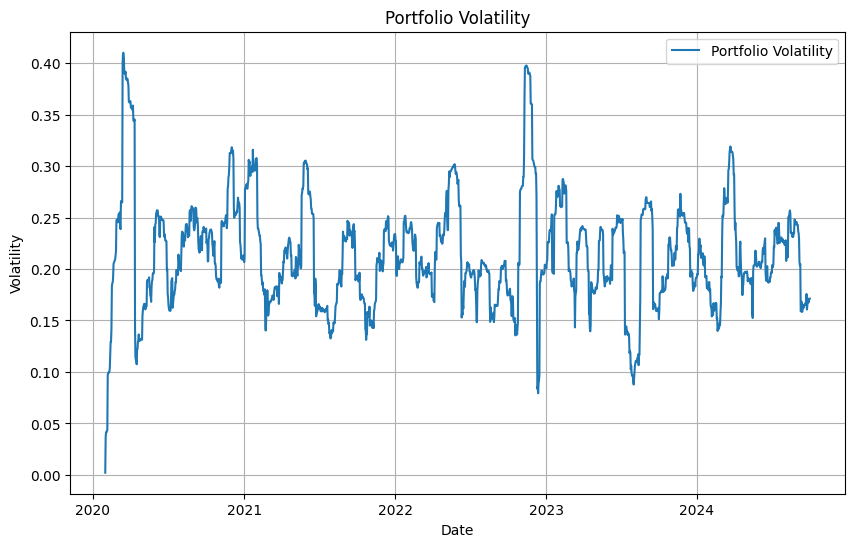

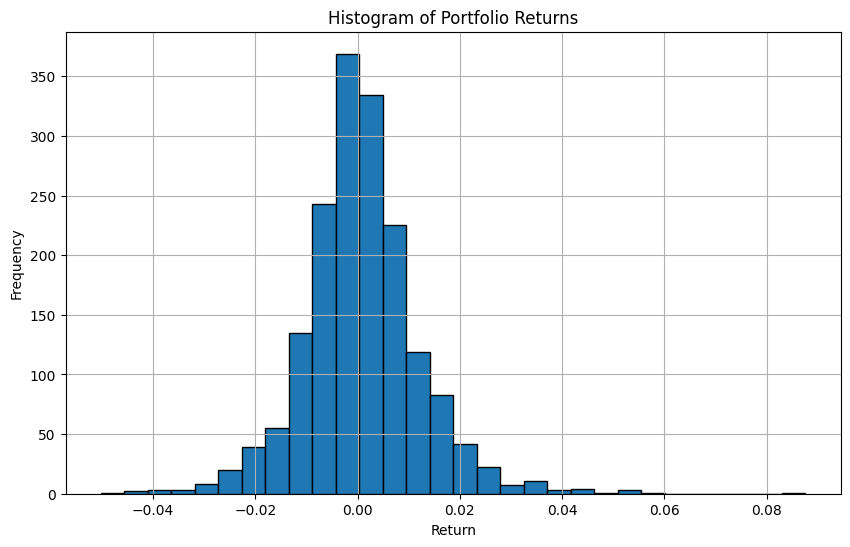

In [49]:
vol_fees_rets = portfolio_values.pct_change()
vol_fees_cumulative = (1 + vol_fees_rets).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(vol_fees_cumulative, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(vol_no_fees_cumulative, label='Cumulative Returns without Fees')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True)

ret_stddev = vol_fees_rets.rolling(30).std() * np.sqrt(365)
plt.figure(figsize=(10, 6))
plt.plot(ret_stddev, label='Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Portfolio Volatility')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.hist(vol_fees_rets, bins=30, edgecolor='black')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Histogram of Portfolio Returns')
plt.grid(True)

# Sharpe Ratio
print(portfolio_values.tail())
print(vol_fees_rets.std() * np.sqrt(365))

In [30]:
# individual signal strategies
trend_signals = ensTrend(backadj_daily)
breakout_signals = breakoutEnsemble(prices=backadj_daily, periods=[8, 16, 32, 64])

# individual strategy weights
trend_simple_weights = simpleWeight(trend_signals)
trend_adj_weights = adjustWeights(trend_simple_weights)

breakout_simple_weights = simpleWeight(breakout_signals)
breakout_adj_weights = adjustWeights(breakout_simple_weights)

In [31]:
# volatility scaling individual strategies
trend_scaled = volatiltyScale(trend_adj_weights, funding_adjusted_daily, daily_vol_target=vol_target)
breakout_scaled = volatiltyScale(breakout_adj_weights, funding_adjusted_daily, daily_vol_target=vol_target)

In [32]:
# calculating no-fee returns
trend_no_fees_rets = (funding_adjusted_daily * trend_scaled.shift(1)).sum(axis = 1)
trend_no_fees_cumulative = (1 + trend_no_fees_rets).cumprod() - 1

breakout_no_fees_rets = (funding_adjusted_daily * breakout_scaled.shift(1)).sum(axis = 1)
breakout_no_fees_cumulative = (1 + breakout_no_fees_rets).cumprod() - 1

In [33]:
# trend individual strategy
initial_value = 100
fee = 0.0005

trend_values = pd.Series(index=funding_adjusted_daily.index)
trend_values.iloc[0] = initial_value

dollar_weights = pd.DataFrame(index=trend_scaled.index, columns=trend_scaled.columns)

for member in tqdm(range(1, len(trend_no_fees_rets))):
    # calculate current value of portfolio
    current_value = trend_values.iloc[member - 1] * (1 + trend_no_fees_rets[member])
    
    # calculate dollar weights
    dollar_weights.iloc[member] = current_value * trend_scaled.iloc[member]
    
    # calculate number of units held
    units_held = dollar_weights.div(main_daily).fillna(0)
    
    # calculate the change in units held
    diff_units_held = units_held.diff().abs()
    
    # calculate transaction cost
    tx_cost = diff_units_held.mul(main_daily).sum(axis=1).iloc[member] * fee
    
    # subtract transaction cost from current portfolio value
    new_value = current_value - tx_cost
    
    # store the new portfolio value
    trend_values.iloc[member] = new_value

100%|██████████| 1734/1734 [00:28<00:00, 60.78it/s]


In [34]:
# breakout individual strategy
initial_value = 100
fee = 0.0005

breakout_values = pd.Series(index=funding_adjusted_daily.index)
breakout_values.iloc[0] = initial_value

dollar_weights = pd.DataFrame(index=breakout_scaled.index, columns=breakout_scaled.columns)

for member in tqdm(range(1, len(breakout_no_fees_rets))):
    # calculate current value of portfolio
    current_value = breakout_values.iloc[member - 1] * (1 + breakout_no_fees_rets[member])
    
    # calculate dollar weights
    dollar_weights.iloc[member] = current_value * breakout_scaled.iloc[member]
    
    # calculate number of units held
    units_held = dollar_weights.div(main_daily).fillna(0)
    
    # calculate the change in units held
    diff_units_held = units_held.diff().abs()
    
    # calculate transaction cost
    tx_cost = diff_units_held.mul(main_daily).sum(axis=1).iloc[member] * fee
    
    # subtract transaction cost from current portfolio value
    new_value = current_value - tx_cost
    
    # store the new portfolio value
    breakout_values.iloc[member] = new_value

100%|██████████| 1734/1734 [00:29<00:00, 59.53it/s]


In [35]:
# individual strategy portfolio and cumulative returns
trend_full_rets = trend_values.pct_change()
trend_full_cumulative = (1 + trend_full_rets).cumprod() - 1

breakout_full_rets = breakout_values.pct_change()
breakout_full_cumulative = (1 + breakout_full_rets).cumprod() - 1

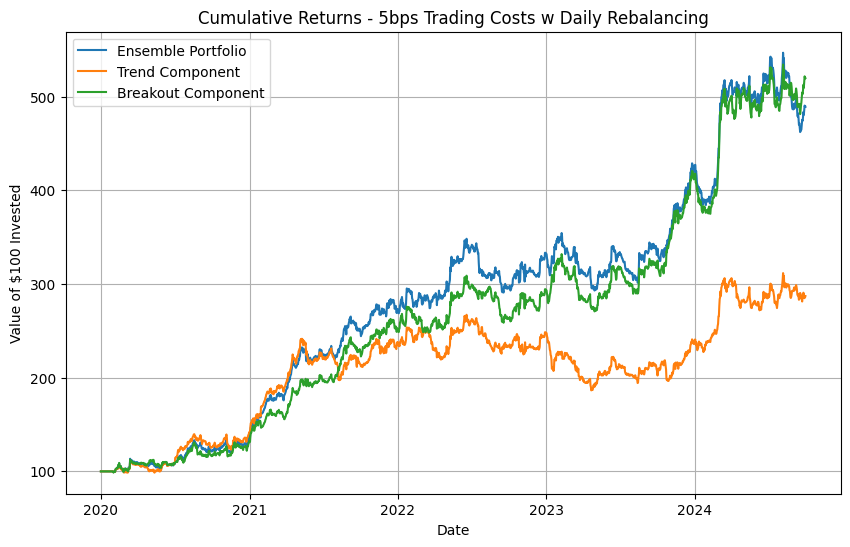

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Ensemble Portfolio')
plt.plot(trend_values, label='Trend Component')
plt.plot(breakout_values, label='Breakout Component')

plt.xlabel('Date')
plt.ylabel('Value of $100 Invested')
plt.title('Cumulative Returns - 5bps Trading Costs w Daily Rebalancing')
plt.legend()
plt.grid(True)

In [41]:
portfolio_values.tail()

open_timestamp
2024-09-26    480.385201
2024-09-27    485.060945
2024-09-28    490.364081
2024-09-29    488.975019
2024-09-30    489.032960
dtype: float64

In [43]:
vol_fees_cumulative.tail()

open_timestamp
2024-09-26    3.803852
2024-09-27    3.850609
2024-09-28    3.903641
2024-09-29    3.889750
2024-09-30    3.890330
dtype: float64

In [40]:
# Sharpe Ratio
print((vol_fees_rets.mean() * 365) / (vol_fees_rets.std() * np.sqrt(365)))
print((1 + vol_fees_rets.mean()) ** 365 - 1)
print((vol_fees_rets.std() * np.sqrt(365)))

1.6336442768843438
0.4304473056863487
0.21924161433457828


In [131]:
# Sharpe Ratio
(trend_full_rets.mean() * 365) / (trend_full_rets.std() * np.sqrt(365))

np.float64(0.9860304915624267)

In [132]:
# Sharpe Ratio
(breakout_full_rets.mean() * 365) / (breakout_full_rets.std() * np.sqrt(365))

np.float64(1.2707826352656797)

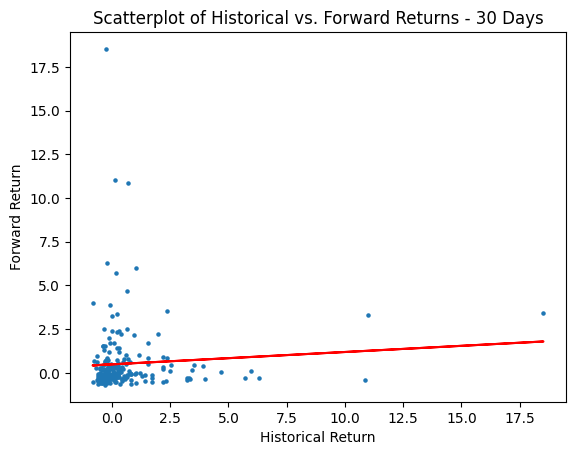

In [161]:
# Data Analysis and Research
# Define the period length for historical and forward returns
period_length = 30

# Create a DataFrame to store results
returns = pd.DataFrame()

# Calculate the historical and forward returns
for asset in main_daily.columns:
    # Ensure that the asset series doesn't start with NaNs
    asset_prices = main_daily[asset].dropna()
    
    # Reference points every period_length days
    ref_points = range(period_length, len(asset_prices) - period_length, period_length)
    
    for ref in ref_points:
        historical_return = (asset_prices[ref] - asset_prices[ref - period_length]) / asset_prices[ref - period_length]
        forward_return = (asset_prices[ref + period_length] - asset_prices[ref]) / asset_prices[ref]
        returns = pd.concat([returns, pd.DataFrame({'Asset': [asset], 'Historical Return': [historical_return], 'Forward Return': [forward_return]})], ignore_index=True)

# Create the scatterplot
plt.scatter(returns['Historical Return'], returns['Forward Return'], s=5)  # Set the size of dots to 10
plt.xlabel('Historical Return')
plt.ylabel('Forward Return')
plt.title('Scatterplot of Historical vs. Forward Returns - 30 Days')

# Add a line of best fit
m, b = np.polyfit(returns['Historical Return'], returns['Forward Return'], 1)
plt.plot(returns['Historical Return'], m * returns['Historical Return'] + b, color='red')

plt.show()


In [162]:
returns['Historical Return'].corr(returns['Forward Return'])


np.float64(0.07095869390700381)

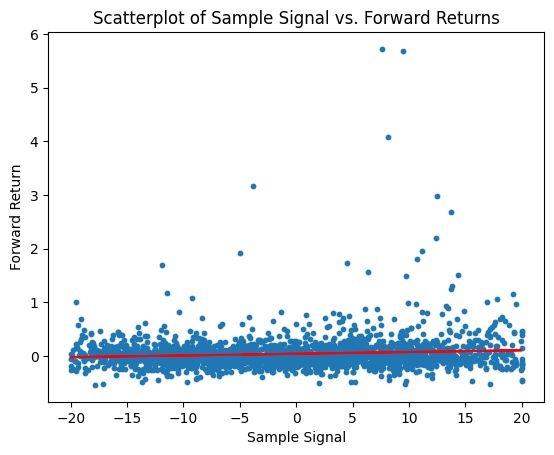

In [166]:
# Define the period length for historical and forward returns
period_length = 14

# Create a DataFrame to store results
returns = pd.DataFrame()

# Calculate the forward returns and sample signal
for asset in main_daily.columns:
    # Ensure that the asset series doesn't start with NaNs
    asset_prices = main_daily[asset].dropna()
    sample_signal = sample_signals[asset].dropna()
    
    # Ensure both series have common dates
    common_dates = asset_prices.index.intersection(sample_signal.index)
    aligned_prices = asset_prices.loc[common_dates]
    aligned_signals = sample_signal.loc[common_dates]
    
    # Reference points every period_length days
    ref_points = range(period_length, len(aligned_prices) - period_length, period_length)
    
    for ref in ref_points:
        forward_return = (aligned_prices[ref + period_length] - aligned_prices[ref]) / aligned_prices[ref]
        signal_value = aligned_signals[ref]
        returns = pd.concat([returns, pd.DataFrame({'Asset': [asset], 'Forward Return': [forward_return], 'Sample Signal': [signal_value]})], ignore_index=True)

# Create the scatterplot
plt.scatter(returns['Sample Signal'], returns['Forward Return'], s=10)  # Set the size of dots to 10
plt.xlabel('Sample Signal')
plt.ylabel('Forward Return')
plt.title('Scatterplot of Sample Signal vs. Forward Returns')

# Add a line of best fit
m, b = np.polyfit(returns['Sample Signal'], returns['Forward Return'], 1)
plt.plot(returns['Sample Signal'], m * returns['Sample Signal'] + b, color='red')

plt.show()



In [167]:
# Prepare the data for OLS regression
X = returns['Sample Signal']
y = returns['Forward Return']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Display the OLS regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Forward Return   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     21.65
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           3.47e-06
Time:                        05:56:35   Log-Likelihood:                -613.41
No. Observations:                2222   AIC:                             1231.
Df Residuals:                    2220   BIC:                             1242.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0433      0.007      6.390